Using device: mps
Classes: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
Train size: 18325, Val size: 3926, Test size: 3928

--- Starting CNN Training ---
Epoch 1/30 | Train Loss: 1.8709 Acc: 0.3428 | Val Loss: 1.5290 Acc: 0.4837
-> New Best Model Saved! (Acc: 0.4837)
Epoch 2/30 | Train Loss: 1.4904 Acc: 0.4873 | Val Loss: 1.2455 Acc: 0.5815
-> New Best Model Saved! (Acc: 0.5815)
Epoch 3/30 | Train Loss: 1.3076 Acc: 0.5538 | Val Loss: 1.1709 Acc: 0.6085
-> New Best Model Saved! (Acc: 0.6085)
Epoch 4/30 | Train Loss: 1.2096 Acc: 0.5884 | Val Loss: 1.1245 Acc: 0.6243
-> New Best Model Saved! (Acc: 0.6243)
Epoch 5/30 | Train Loss: 1.1318 Acc: 0.6144 | Val Loss: 1.0543 Acc: 0.6518
-> New Best Model Saved! (Acc: 0.6518)
Epoch 6/30 | Train Loss: 1.0631 Acc: 0.6380 | Val Loss: 1.0274 Acc: 0.6607
-> New Best Model Saved! (Acc: 0.6607)
Epoch 7/30 | Train Loss: 1.0160 Acc: 0.6574 | Val Loss: 0.9988 Acc: 0.6755
-> New Best Model Saved! (

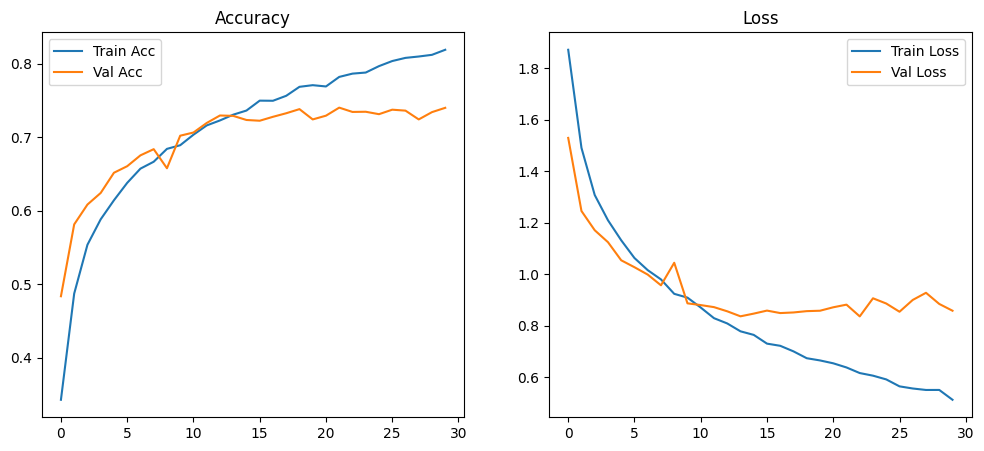


--- Evaluating Best CNN on Test Set ---
              precision    recall  f1-score   support

        cane       0.69      0.78      0.73       730
     cavallo       0.74      0.66      0.70       388
    elefante       0.74      0.63      0.68       209
    farfalla       0.86      0.79      0.82       297
     gallina       0.84      0.81      0.82       442
       gatto       0.55      0.46      0.50       239
       mucca       0.62      0.47      0.53       280
      pecora       0.57      0.68      0.62       294
       ragno       0.86      0.88      0.87       773
  scoiattolo       0.60      0.70      0.65       276

    accuracy                           0.73      3928
   macro avg       0.71      0.69      0.69      3928
weighted avg       0.73      0.73      0.73      3928



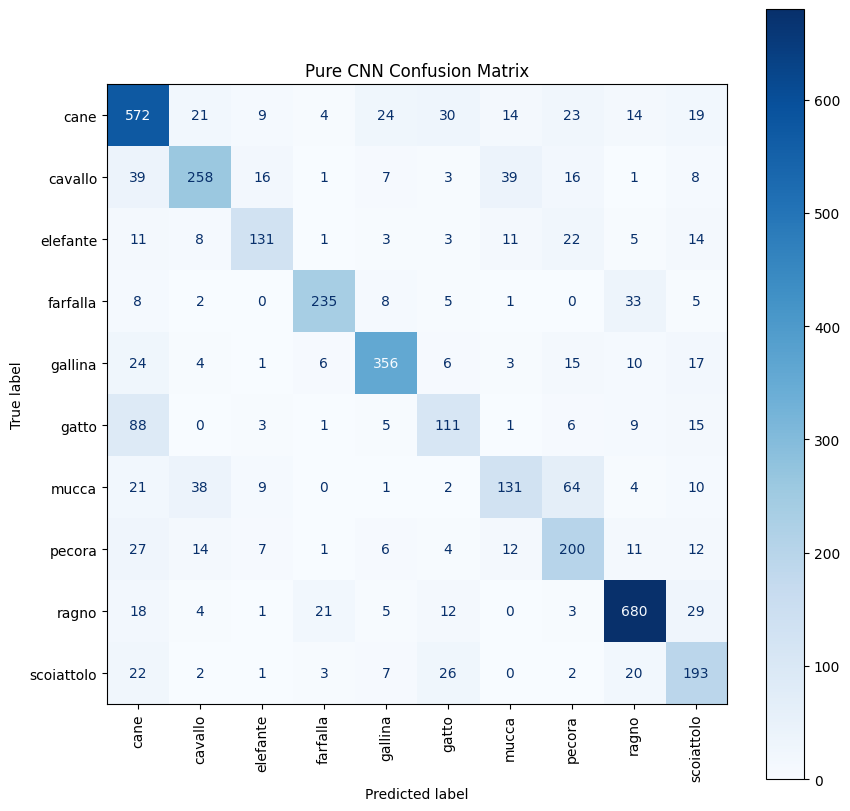

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import os
import time

# --- CONFIGURATION ---
DATA_DIR = "/Users/vipulsharma/Downloads/1_3/raw-img"
IMG_SIZE = (150, 150)
BATCH_SIZE = 32
SEED = 123
NUM_EPOCHS = 30
LEARNING_RATE = 0.001
BEST_MODEL_PATH = "best_pure_cnn.pth"

# Set device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Set seeds
torch.manual_seed(SEED)
np.random.seed(SEED)

# --- DATA PREPARATION ---
train_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, scale=(0.9, 1.1)),
    transforms.ToTensor()
])

val_test_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor()
])

# Load Dataset
full_dataset = datasets.ImageFolder(root=DATA_DIR, transform=train_transform)
class_names = full_dataset.classes
print(f"Classes: {class_names}")

# Split (70% Train, 15% Val, 15% Test)
dataset_size = len(full_dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size

generator = torch.Generator().manual_seed(SEED)
train_indices, val_indices, test_indices = random_split(
    range(dataset_size), [train_size, val_size, test_size], generator=generator
)

# Create Subsets
train_ds = Subset(datasets.ImageFolder(DATA_DIR, transform=train_transform), train_indices)
val_ds = Subset(datasets.ImageFolder(DATA_DIR, transform=val_test_transform), val_indices)
test_ds = Subset(datasets.ImageFolder(DATA_DIR, transform=val_test_transform), test_indices)

# Create Loaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Train size: {len(train_ds)}, Val size: {len(val_ds)}, Test size: {len(test_ds)}")

# --- MODEL ARCHITECTURE ---
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Flatten size calculation: 150 -> 75 -> 37 -> 18 (128 * 18 * 18)
        self.flattened_size = 128 * 18 * 18
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flattened_size, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes) 
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# --- TRAINING FUNCTION ---
def train_model():
    model = CustomCNN(len(class_names)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    print("\n--- Starting CNN Training ---")
    for epoch in range(NUM_EPOCHS):
        start = time.time()
        
        # Training Phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        epoch_loss = running_loss / len(train_ds)
        epoch_acc = correct / total
        
        # Validation Phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                
        val_epoch_loss = val_loss / len(val_ds)
        val_epoch_acc = val_correct / val_total
        
        # Save History
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)
        history['val_loss'].append(val_epoch_loss)
        history['val_acc'].append(val_epoch_acc)
        
        print(f"Epoch {epoch+1}/{NUM_EPOCHS} | "
              f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | "
              f"Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}")
        
        if val_epoch_acc > best_acc:
            best_acc = val_epoch_acc
            torch.save(model.state_dict(), BEST_MODEL_PATH)
            print(f"-> New Best Model Saved! (Acc: {best_acc:.4f})")
            
    return history

# --- EVALUATION FUNCTION ---
def evaluate_model():
    print("\n--- Evaluating Best CNN on Test Set ---")
    model = CustomCNN(len(class_names)).to(device)
    model.load_state_dict(torch.load(BEST_MODEL_PATH))
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    # Metrics
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
    plt.title("Pure CNN Confusion Matrix")
    plt.show()

# --- EXECUTION ---
if __name__ == "__main__":
    history = train_model()
    
    # Plot Training History
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    evaluate_model()

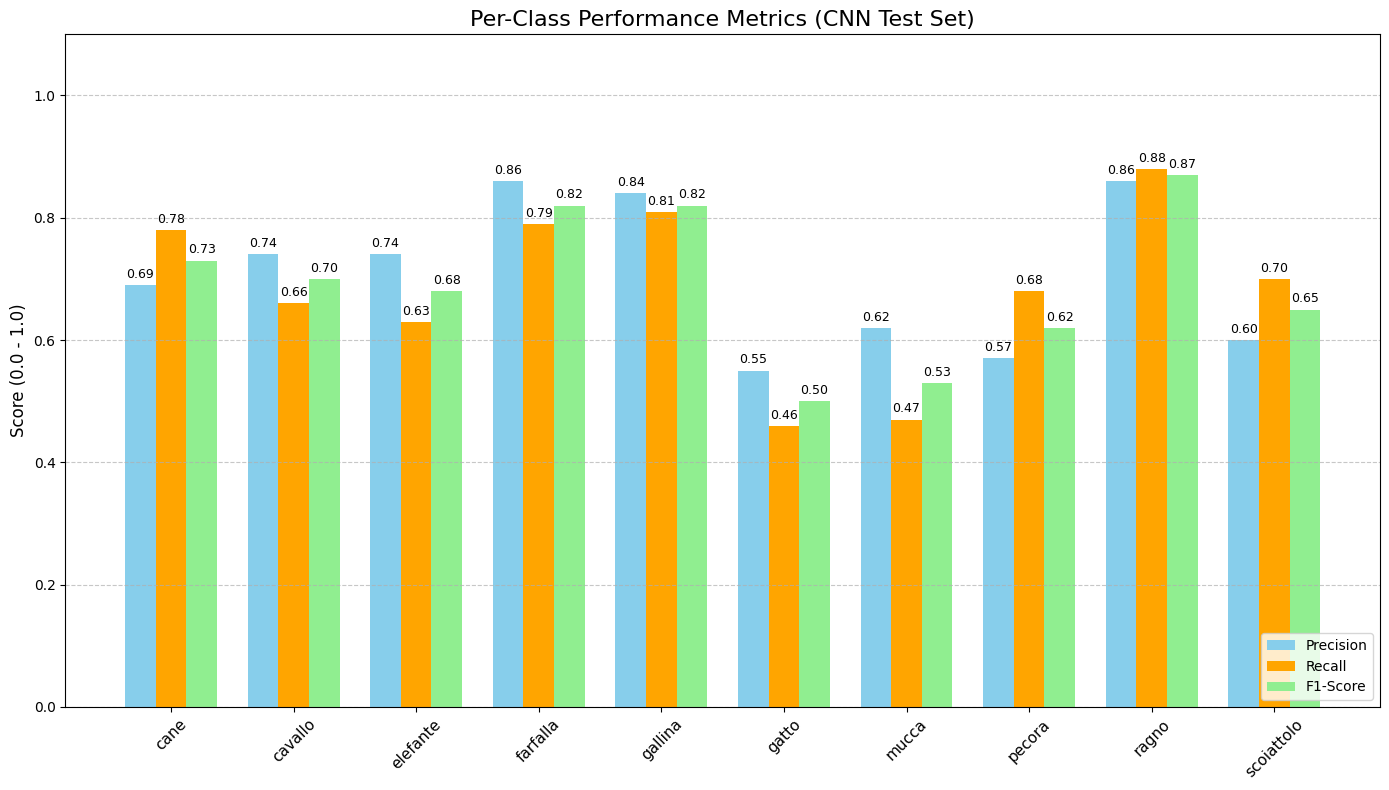

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1. Prepare the data
data = {
    'Class': ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo'],
    'Precision': [0.69, 0.74, 0.74, 0.86, 0.84, 0.55, 0.62, 0.57, 0.86, 0.60],
    'Recall':    [0.78, 0.66, 0.63, 0.79, 0.81, 0.46, 0.47, 0.68, 0.88, 0.70],
    'F1-Score':  [0.73, 0.70, 0.68, 0.82, 0.82, 0.50, 0.53, 0.62, 0.87, 0.65]
}

df = pd.DataFrame(data)

# 2. Setup the plot
x = np.arange(len(df['Class']))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(14, 8))

# 3. Create the bars
rects1 = ax.bar(x - width, df['Precision'], width, label='Precision', color='#87CEEB') # SkyBlue
rects2 = ax.bar(x, df['Recall'], width, label='Recall', color='#FFA500')       # Orange
rects3 = ax.bar(x + width, df['F1-Score'], width, label='F1-Score', color='#90EE90') # LightGreen

# 4. Add labels, title, and custom x-axis tick labels
ax.set_ylabel('Score (0.0 - 1.0)', fontsize=12)
ax.set_title('Per-Class Performance Metrics (CNN Test Set)', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(df['Class'], rotation=45, fontsize=11)
ax.set_ylim(0, 1.1) # Set Y limit slightly higher for labels
ax.legend(loc='lower right')
ax.grid(axis='y', linestyle='--', alpha=0.7)

# 5. Function to attach a text label above each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.tight_layout()
plt.show()